# Precision and Resolution Analysis

This serve as an initial investigation on the precision of a polar plotter machine.

A typical diagram of the plotter machine:

![](./image/simple_diagram.drawio.png)

---

We assuming the motor ($u$ and $v$) are horizontally aligned. And a X-Y plane is defined as:

![](./image/simple_diagram_definition.drawio.png)


In [48]:
import math

In [49]:
# Define the motor U, V position. The unit is in mm
x_u = 0
x_v = 1000

def xy2uv(x, y):
    s_y = y ** 2
    u = math.sqrt((x_u - x) ** 2 + s_y)
    v = math.sqrt((x_v - x) ** 2 + s_y)
    return u, v



## Precision on height (Y)

Compare the delta movements of string u and v at different heights: (the larger the better, means we have more resolution)

In [50]:
dx = (x_u - x_v) * 0.9  # 90% of X length
x_middle = (x_u + x_v) / 2
x1 = x_middle - (dx / 2)
x2 = x_middle + (dx / 2)

for y in [100, 900]:
    u1, v1 = xy2uv(x1, y)
    u2, v2 = xy2uv(x2, y)
    print(f'When y={y} and delta_x={dx}: delta_u={u2-u1:.2f}, delta_v={v2-v1:.2f}')


When y=100 and delta_x=-900.0: delta_u=-843.45, delta_v=843.45
When y=900 and delta_x=-900.0: delta_u=-407.24, delta_v=407.24


## Precision on height (X)

Compare the delta movements of string u and v at when move vertically at different x posistions: (the larger the better)

In [51]:
dy = 800
y1 = 100
y2 = y1 + dy

x_side = x_u + (x_v - x_u) * 0.1
x_middle = (x_u + x_v) / 2
for x in [x_side, x_middle]:
    u1, v1 = xy2uv(x, y1)
    u2, v2 = xy2uv(x, y2)
    print(f'When x={x} and delta_y={dy}: delta_u={u2-u1:.2f}, delta_v={v2-v1:.2f}')


When x=100.0 and delta_y=800: delta_u=764.12, delta_v=367.25
When x=500.0 and delta_y=800: delta_u=519.66, delta_v=519.66


## U-V precision mapping to X-Y


### Define resolution

For a given point $P(x,y)$, let's define the conversion action between the $X$-$Y$ and $U$-$V$ system as $\text{xy2uv}()$ and $\text{uv2xy}()$, so we have

$$ (x,y)=\text{uv2xy}(u,v) $$
and
$$ (u,v)=\text{xy2uv}(x,y) $$


The motor resolution step length $S_L$ is the minimum string length that a stepper motor can make.

For motor $U$ and $V$, we have their resolution step lengths denoted as $S_{L_{u}}$ and $S_{L_{v}}$.

By applying _small_ increment amounts $(\Delta x, \Delta y)$ on X and Y from $P(x, y)$, we have $P'(x', y')=(x + \Delta x, y +\Delta y)$

$$ (u', v') = xy2uv(x', y') $$

And we have

$$ (\Delta u, \Delta v) = (u', v') - (u, v) $$

Now, let's define 

$$ k_{|P-P'|}|u = \frac{\Delta u}{S_{L_{u}}} $$

Effectively, $k|u$ means the relative resolution of the motor $U$, moving between point $P$ and $P'$.

and similarily, we also have $k_{|P-P'|}|v$:

$$ k_{|P-P'|}|v = \frac{\Delta v}{S_{L_{v}}} $$

Finally, let's define the relative resolution $K$,

$$ K = \text{min}(k|u, k|v) $$

Intuitively, for a delta movement $(\Delta x, \Delta y)$, $K$ is the multiple of the stepper motor resolution i.e. $S_L$ in $U$-$V$.

For example, $K < 1$ means we can not move the $(\Delta x, \Delta y)$ reliably, and $K > 1$ means the motors need to move a string length longer the it's minimum step length. In the case of $K \subseteq \mathbb{Z}^+ $ (which include $K = 1$), we can move to the exact $P'$, which is ideal. Thus generally larger the $K$, better the relative resolution.


In [52]:
def uv2xy(u, v):
    x = (x_u + x_v) - (u * u - v * v) / (x_u - x_v)
    x = x / 2
    y = (v ** 2) - (x_v - x) ** 2
    if y <= 0:
        return math.nan, math.nan
    y = math.sqrt(y)
    return x, y

In [53]:
# Let's do a simple verification to see if we do the math right
x, y = 25., 80.
x_new, y_new = uv2xy(*xy2uv(x, y))
print(x, x_new, 'diff =', x - x_new)
print(y, y_new, 'diff =', y - y_new)

25.0 25.0 diff = 0.0
80.0 80.0 diff = 0.0


However, knowing relative resolution of $|P-P'|$ may not be so usefully for making design decisions.

Instead, we can work things another way around.

For each motor, it can reel-in (i.e. the length of string decreased), pay-out (i.e. the length of string increased), and of course, stay still.

Say at $P(u,v)$, the motor $V$ reel-in by $S_{L_{v}}$, this gives us $P'(u, v')=(u, v - S_{L_{v}})$

We will have

$$ (x', y') = \text{uv2xy}(u, v') $$

The $x'$ and $y'$ are the $S_{L_{v}}$ translated on $X$-$Y$.

At any given point, all the possible states of the both motor can be listed as:

|       | $U$ | $V$ |
|:-----:|:---:|:---:|
| $P_0$ |  0  |  0  |
| $P_1$ |  0  |  +  |
| $P_2$ |  0  |  -  |
| $P_3$ |  +  |  0  |
| $P_4$ |  +  |  +  |
| $P_5$ |  +  |  -  |
| $P_6$ |  -  |  0  |
| $P_7$ |  -  |  +  |
| $P_8$ |  -  |  -  |

where: `0` means motor stay still, `+` means pay-out, and `-` means reel-in.

Let's now define resolution $r$:

$$ r_{P}|x = \max(P_1|x, P_2|x, \text{...}) $$

and 

$$ r_{P}|y = \max(P_1|y, P_2|y, \text{...}) $$


where

$$ P|x = |P - P_0||x $$
$$ P|y = |P - P_0||y $$

And finally, the united resolution $R$:

$$ R_P = \max(r_{P}|x, r_{P}|y) $$

The united resolution $R_P$ means the worst resolution on $X$-$Y$, when at the point $P$ a smallest possible string length changes (i.e. $S_{L_{u}}$ and $S_{L_{v}}$ for the motor $U$ and $V$).

Thus, **smaller** the $R$ value means **better** the control on the given point, the more desired.

In [54]:
def calc_resolution(x, y, s_l):
    u, v = xy2uv(x, y)
    assert u>=0
    assert v>=0

    res_x, res_y = 0, 0
    for i in [0, 1, -1]:
        for j in [0, 1, -1]:
            if (i, j) == (0, 0):
                continue
            dx, dy = uv2xy(u + i*s_l, v + j*s_l)
            rx = abs(x - dx)
            ry = abs(y - dy)
            res_x = max(res_x, rx)
            res_y = max(res_y, ry)
    return res_x, res_y


In [55]:
# Define the minimum motor resolution length (also in mm)
s_l = 2

x, y = 50, 80
res_x, res_y = calc_resolution(x, y, s_l)

print('Explanation:')
print(f'At P(x, y)=({x}, {y}), the resolution is about ({res_x}, {res_y}).')
print(f'This means, a smallest possible movement ({s_l}mm) on the motor u and v, makes a movment of {res_x:.2f}mm in x direction, and {res_y:.2f}mm in y at point P.')
print('Smaller the value means better the resolution on the given point.')

Explanation:
At P(x, y)=(50, 80), the resolution is about (2.095404563475597, 3.5023886439385166).
This means, a smallest possible movement (2mm) on the motor u and v, makes a movment of 2.10mm in x direction, and 3.50mm in y at point P.
Smaller the value means better the resolution on the given point.


In [56]:
# Let's see more examples to get some intuitions
li = [(10, 10), (990, 10), (500, 10), (500, 500)]

for x, y in li:
    res_x, res_y = calc_resolution(x, y, s_l)
    print(f'At P(x, y)=({x}, {y}), the resolution is about ({res_x:.2f}, {res_y:.2f}).')


At P(x, y)=(10, 10), the resolution is about (2.01, 7.86).
At P(x, y)=(990, 10), the resolution is about (2.01, 7.86).
At P(x, y)=(500, 10), the resolution is about (2.00, 35.87).
At P(x, y)=(500, 500), the resolution is about (2.83, 2.83).


In [65]:
import numpy as np

xy_map = []
x_length = x_v - x_u

for y in range(300):
    col = []
    for x in range(x_length):
        res_xy = list(calc_resolution(x, y, s_l))
        col.append(res_xy)
    xy_map.append(col)


xy_map = np.array(xy_map)
xy_map

array([[[1.25000000e-04, 4.99999984e-01],
        [4.99625000e-01, 1.41385961e+00],
        [4.99125000e-01, 1.99849844e+00],
        ...,
        [4.98625000e-01, 2.44642413e+00],
        [4.99125000e-01, 1.99849844e+00],
        [4.99625000e-01, 1.41385961e+00]],

       [[5.00500250e-01, 9.77650496e-01],
        [5.00207357e-01, 8.47432069e-01],
        [5.00118284e-01, 1.28685595e+00],
        ...,
        [5.00081390e-01, 1.67336188e+00],
        [5.00118284e-01, 1.28685595e+00],
        [5.00207357e-01, 8.47432069e-01]],

       [[5.01001000e-01, 5.86140743e-01],
        [5.00619035e-01, 1.12319871e+00],
        [5.00415216e-01, 9.70047418e-01],
        ...,
        [5.00303779e-01, 1.25407921e+00],
        [5.00415216e-01, 9.70047418e-01],
        [5.00619035e-01, 1.12319871e+00]],

       ...,

       [[6.70086282e-01, 5.00757194e-01],
        [6.69607837e-01, 5.01493648e-01],
        [6.69131113e-01, 5.02755001e-01],
        ...,
        [6.68656112e-01, 5.04018769e-01],
     

Resolution on X


<AxesSubplot:>

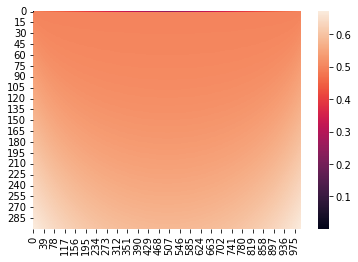

In [66]:
import seaborn as sns

print('Resolution on X')
sns.heatmap(xy_map[:,:,0])

Resolution on Y


<AxesSubplot:>

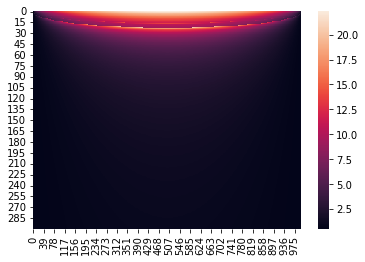

In [67]:
print('Resolution on Y')
sns.heatmap(xy_map[:,:,1])


Resolution on combined


<AxesSubplot:>

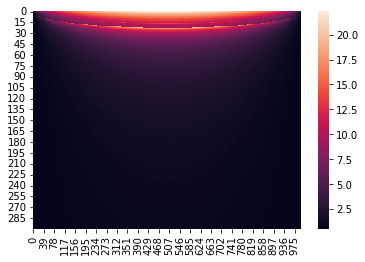

In [68]:
print('Resolution on combined')
sns.heatmap(np.maximum(xy_map[:,:,0], xy_map[:,:,1]))

## Take-away

- Precision along Y direction is way more significant
- Longer the pull cable, better the resolution